## Intent classification

Dataset: https://www.kaggle.com/datasets/arunmohan003/customer-service-intent-classification

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import nltk
import numpy as np
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from stemming.porter2 import stem

In [3]:
import xgboost as xgb

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eugenio.mercuriali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Grid style
sns.set(style="darkgrid")

# Figsize
sns.set(rc={'figure.figsize': (15, 8)})

### EDA

In [6]:
splits = {
    'train': 'Training',
    'val': 'Validation',
    'test': 'Testing',
}

split = splits['train']

In [7]:
path = f'customer_service_dataset/Bitext_Sample_Customer_Service_{split}_Dataset.csv'

In [8]:
df_train = pd.read_csv(path)

In [9]:
df_train.head()

,utterance,intent,category,tags
0,would it be possible to cancel the order I made?,cancel_order,ORDER,BIP
1,cancelling order,cancel_order,ORDER,BK
2,I need assistance canceling the last order I h...,cancel_order,ORDER,B
3,problem with canceling the order I made,cancel_order,ORDER,B
4,I don't know how to cancel the order I made,cancel_order,ORDER,B


In [10]:
df_train['intent'].value_counts()

get_invoice                 268
payment_issue               263
check_invoice               258
contact_customer_service    253
complaint                   252
review                      248
cancel_order                246
check_cancellation_fee      246
check_payment_methods       246
set_up_shipping_address     246
track_order                 245
place_order                 243
check_refund_policy         240
get_refund                  239
registration_problems       239
recover_password            239
track_refund                239
newsletter_subscription     238
create_account              237
delivery_options            236
delete_account              236
delivery_period             236
edit_account                233
change_order                232
switch_account              228
change_shipping_address     228
contact_human_agent         225
Name: intent, dtype: int64

In [11]:
def show_missing(df):

    missing_values_count = df.isnull().sum()
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'missing_values_count': missing_values_count,
                                     'percent_missing': percent_missing})

    # Visualizing % missing values by column

    df.isna().mean().sort_values().plot(
        kind='bar',
        figsize=(15,4),
        ylabel='Ratio of missing values per feature'
    )

    plt.title('Percentage of missing values per feature', fontsize=18)
    plt.xlabel('Columns', fontsize=14)
    plt.ylabel('Ratio of missing values per feature', fontsize=14)

    # Exact % of missing values

    print(missing_value_df.sort_values(by='percent_missing', ascending=False).reset_index(drop=True))

  column_name  missing_values_count  percent_missing
0   utterance                     0              0.0
1      intent                     0              0.0
2    category                     0              0.0
3        tags                     0              0.0


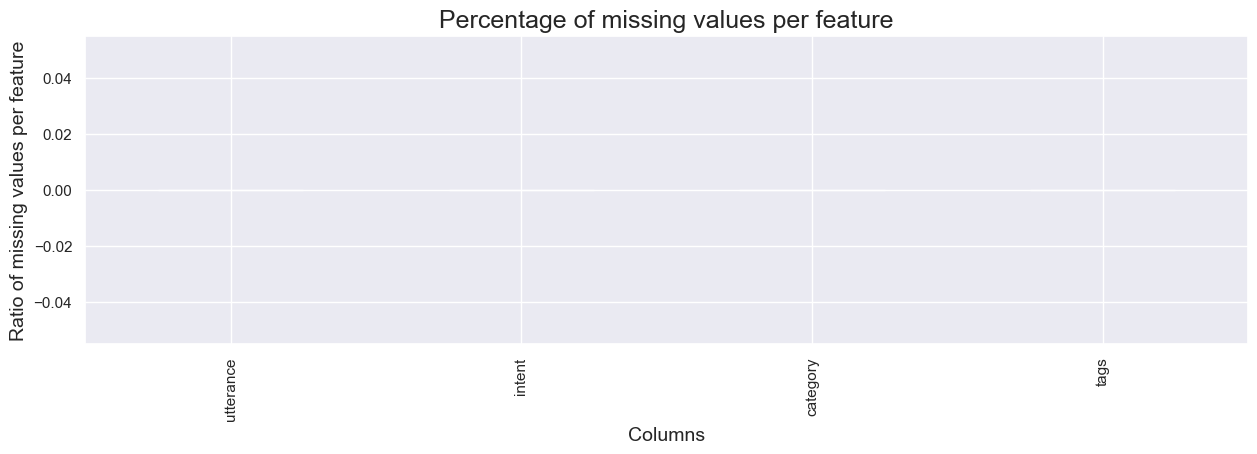

In [12]:
show_missing(df_train)

### Data prep

#### Removing stopwords

In [13]:
tokens_to_drop = [
    'for',
    'the',
    'with',
]

In [14]:
def is_english(s: str) -> bool:
    """Checks if a string is not English by encoding and decoding it
    :param s: string to check
    :returns: bool, True if s is English, else False
    """
    if s is not None:
        try:
            s.encode(encoding='utf-8').decode('ascii')
        except UnicodeDecodeError:
            return False
        else:
            return True

def remove_symbols(s: str) -> str:
    """Applies regex to a string to remove special characters
    :param s: string to apply regex on
    :returns: with no special characters
    """
    if s is not None:
        return re.sub(r'[€–‹^»•«º£—®*!@#‹$%&|_Ø´ø™°☽·✩麓²’-]', '', s)


def remove_substrings(s: str, s_to_remove: str) -> str:
    """Applies regex to a string to remove all substrings in a second string
    :param s: string to apply regex on
    :param s_to_remove: string to split to generate substrings
    :returns: s without s_to_remove
    """
    if s is not None:
        s = s.lower()
        s_to_remove = s_to_remove.lower()
        sub_s = s_to_remove.split()  # substrings to remove
        return re.sub(r'|'.join(map(re.escape, sub_s)), '', s)
    

def remove_stopwords(s):
    return ' '.join([x for x in s.split() if x.lower() not in stopwords.words('english') + tokens_to_drop and len(x) > 2])

v_is_english = np.vectorize(lambda x: is_english(x))
v_remove_symbols = np.vectorize(lambda x: remove_symbols(x))
v_remove_substrings = np.vectorize(lambda x, y: remove_substrings(x, y)) 
v_remove_stopwords = np.vectorize(remove_stopwords)

In [15]:
df_train['tokenized_utterance'] = v_remove_stopwords(df_train['utterance'])

### Tokenization

In [16]:
# Cleaning + tokenization
# We will remove numbers as well: removing punctuation also removed dots representing decimals

# Removing punctuation
df_train['tokenized_utterance'] = df_train['tokenized_utterance'].str.replace('[^\\w\\s]', '', regex=True).replace("'", '')

# Removing numbers
df_train['tokenized_utterance'] = df_train['tokenized_utterance'].str.replace('\\d+', '', regex=True)

In [17]:
df_train

,utterance,intent,category,tags,tokenized_utterance
0,would it be possible to cancel the order I made?,cancel_order,ORDER,BIP,would possible cancel order made
1,cancelling order,cancel_order,ORDER,BK,cancelling order
2,I need assistance canceling the last order I h...,cancel_order,ORDER,B,need assistance canceling last order made
3,problem with canceling the order I made,cancel_order,ORDER,B,problem canceling order made
4,I don't know how to cancel the order I made,cancel_order,ORDER,B,know cancel order made
...,...,...,...,...,...
6534,I do not know what I have to do to track the r...,track_refund,REFUND,BE,know track refund
6535,check refund status,track_refund,REFUND,BK,check refund status
6536,help me check the refund status,track_refund,REFUND,B,help check refund status
6537,how can I check if there is any updates on my ...,track_refund,REFUND,BIM,check updates refund


In [18]:
# Tokenization

df_train['tokenized_utterance'] = [word_tokenize(x) for x in df_train['tokenized_utterance']]

In [19]:
doc_list = [' '.join(x) for x in df_train['tokenized_utterance']]

In [20]:
doc_list[:10]

['would possible cancel order made',
 'cancelling order',
 'need assistance canceling last order made',
 'problem canceling order made',
 'know cancel order made',
 'help cancel order made',
 'would like know order cancellations',
 'could help cancelling order',
 'know cancel order made',
 'help cancelling last order']

In [21]:
len(doc_list)

6539

In [22]:
df_train['clean_doc'] = doc_list

### Tf-idf

### Tfidf

**tf-idf** is the product of the term frequency and the inverse document frequency:

$$\text{tf-idf}(t,d)=\text{tf (t,d)}\times \text{idf}(t,d)$$

* tf(t, d) is the **term frequency** of the word *t* in the document *d*
* The **inverse document frequency** *idf(t, d)* can be calculated as:

$$\text{idf}(t,d) = \text{log}\frac{n_d}{1+\text{df}(d, t)},$$

* $n_d$ is the total number of documents
* *df(d, t)* is the number of documents *d* that contain the term *t*. 

(adding 1 to the denominator prevents divide-by-zero errors).

Scikit-learn implements the `TfidfVectorizer` (by combining `CountVectorizer` and the `TfidfTransformer`), that takes 1d array of texts as input and transforms them into tf-idfs.

### Vector Space Model – Cosine Similarity

tf-idf is a transformation we apply to texts to get two real-valued vectors - from each document we derive a vector, so the set of documents in a collection can be seen as a set of vectors in a vector space, where each term will have its own axis. We can find out the similarity between any two documents using **cosine similarity**.

We can obtain the cosine similarity of any pair of vectors by taking their dot product and dividing that by the product of their norms. That yields the cosine of the angle between the vectors.

As θ ranges from 0 to 90 degrees, cos(θ) ranges from 1 to 0 (θ can only range from 0 to 90 degrees tf-idf vectors are non-negative).


In [23]:
# Tfidf model

vector = TfidfVectorizer(
    max_df=0.3,  # drop words that occur in more than X percent of documents
    stop_words='english',  # remove stop words
    lowercase=True,  # Convert everything to lower case
    use_idf=True,  # Use idf
    norm=u'l2',  # Normalization - L2 norm
    smooth_idf=True  # Prevents divide-by-zero errors
)

In [24]:
text_content = df_train['clean_doc']
tfidf = vector.fit_transform(text_content)

### Dimensionality reduction

Let's apply a PCA first to reduce the number of dimensions. Our best bet is probably to use **TruncatedSVD**, which is a PCA-like dimensionality reduction algorithm (using by default **Randomized SVD**) which works on sparse data. In particular, truncated SVD works on term count/tf-idf matrices - in this context, it is known as **Latent Semantic Analysis (LSA)**.

We also tuned the number of Principal Components that we want to use: we looked at the percentage of explained variance at 100, 500, 750, 1000 PCs and checked where we were stading. We could have also checked other values for the optimal number of PCs, but fitting the model is computationally expensive, given the sparsity that we have in our data.

In [25]:
k = 100
pc_model = TruncatedSVD(n_components=k).fit(tfidf)
pc_model.explained_variance_ratio_.sum()

0.813088494414416

In [26]:
tfidf_reduced = pc_model.transform(tfidf)
tfidf_reduced_normal = normalize(tfidf_reduced, axis=1, norm='l2')

In [27]:
tfidf_reduced_normal

array([[ 0.20749157,  0.0132243 ,  0.40004551, ...,  0.00542412,
         0.00100843,  0.00077229],
       [ 0.19101083,  0.01123472,  0.40394801, ..., -0.07771221,
         0.03937568,  0.0434185 ],
       [ 0.33983308,  0.02923444,  0.37937803, ..., -0.06069853,
         0.02025446,  0.02910642],
       ...,
       [ 0.52368074, -0.3624721 , -0.24766351, ..., -0.00184057,
         0.00073205, -0.00623598],
       [ 0.32977527, -0.30922741, -0.27115934, ...,  0.09952535,
        -0.20078323, -0.01559451],
       [ 0.38156565, -0.35235903, -0.31585095, ..., -0.04763349,
        -0.02362997,  0.03700865]])

In [28]:
tfidf_df = pd.DataFrame(tfidf_reduced_normal)

In [29]:
tfidf_df.columns = ['lf_' + str(x) for x in tfidf_df.columns]

### Model training

In [30]:
train_set = pd.concat([df_train.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

In [31]:
train_set

,utterance,intent,category,tags,tokenized_utterance,clean_doc,lf_0,lf_1,lf_2,lf_3,...,lf_90,lf_91,lf_92,lf_93,lf_94,lf_95,lf_96,lf_97,lf_98,lf_99
0,would it be possible to cancel the order I made?,cancel_order,ORDER,BIP,"[would, possible, cancel, order, made]",would possible cancel order made,0.207492,0.013224,0.400046,0.179959,...,0.010199,-0.025067,-0.018309,0.000771,0.016837,0.008974,-0.012020,0.005424,0.001008,0.000772
1,cancelling order,cancel_order,ORDER,BK,"[cancelling, order]",cancelling order,0.191011,0.011235,0.403948,0.178814,...,-0.029649,-0.073487,-0.018384,-0.020852,0.015225,0.021041,0.010041,-0.077712,0.039376,0.043418
2,I need assistance canceling the last order I h...,cancel_order,ORDER,B,"[need, assistance, canceling, last, order, made]",need assistance canceling last order made,0.339833,0.029234,0.379378,0.026934,...,-0.007323,-0.070451,-0.054238,-0.005523,-0.000603,0.001070,0.000348,-0.060699,0.020254,0.029106
3,problem with canceling the order I made,cancel_order,ORDER,B,"[problem, canceling, order, made]",problem canceling order made,0.152991,0.012762,0.319452,0.140197,...,-0.153396,-0.003972,0.136660,-0.030667,-0.192078,0.008544,-0.000428,0.101436,-0.014771,-0.054255
4,I don't know how to cancel the order I made,cancel_order,ORDER,B,"[know, cancel, order, made]",know cancel order made,0.322537,0.021395,0.469883,0.184557,...,0.007268,-0.029741,-0.022609,-0.003094,0.018313,0.014066,-0.010319,0.004288,0.004168,0.002862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6534,I do not know what I have to do to track the r...,track_refund,REFUND,BE,"[know, track, refund]",know track refund,0.354602,-0.134786,0.136082,0.326823,...,0.013954,-0.000053,-0.013164,0.006470,0.006338,-0.006428,0.014501,0.001215,0.005194,-0.014089
6535,check refund status,track_refund,REFUND,BK,"[check, refund, status]",check refund status,0.410966,-0.387298,-0.300004,0.463064,...,0.003931,0.010942,0.000691,0.003307,0.000057,-0.009403,0.001416,-0.007679,0.007624,0.001272
6536,help me check the refund status,track_refund,REFUND,B,"[help, check, refund, status]",help check refund status,0.523681,-0.362472,-0.247664,0.368538,...,0.011414,0.005894,-0.015440,0.006780,-0.010477,-0.020448,0.000159,-0.001841,0.000732,-0.006236
6537,how can I check if there is any updates on my ...,track_refund,REFUND,BIM,"[check, updates, refund]",check updates refund,0.329775,-0.309227,-0.271159,0.328649,...,-0.044144,-0.135899,-0.006875,-0.076046,0.030854,0.363126,-0.131717,0.099525,-0.200783,-0.015595


In [32]:
intents = list(df_train['intent'].unique())

In [33]:
len(intents)

27

In [34]:
# Mapping class number to intent
intent_map = dict(zip(range(len(intents)), intents))
class_map = dict(zip(intents, range(len(intents))))

In [35]:
train_set['class'] = train_set['intent'].map(class_map)

In [36]:
model = xgb.XGBClassifier(objective='multi:softmax')

In [37]:
features = [
    f'lf_{x}' for x in range(k)
]

In [38]:
model.fit(train_set[features], train_set['class'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

In [39]:
split = splits['val']

path = f'customer_service_dataset/Bitext_Sample_Customer_Service_{split}_Dataset.csv'

In [40]:
df_val = pd.read_csv(path)

In [41]:
df_val['class'] = df_val['intent'].map(class_map)

### Validation and test set prep

We first need to create a preprocessing function to apply the transformations we used (trained on the train set only) also on validation and test sets.

In [42]:
def preprocess_data(data, tfidf_vectorizer, svd_model):
    
    df = data.copy()
    
    # Remove stopwords
    df['tokenized_utterance'] = v_remove_stopwords(df['utterance'])
    # Cleaning + tokenization
    # We will remove numbers as well: removing punctuation also removed dots representing decimals

    # Removing punctuation
    df['tokenized_utterance'] = df['tokenized_utterance'].str.replace('[^\\w\\s]', '', regex=True).replace("'", '')

    # Removing numbers
    df['tokenized_utterance'] = df['tokenized_utterance'].str.replace('\\d+', '', regex=True)
    
    # Tokenization
    df['tokenized_utterance'] = [word_tokenize(x) for x in df['tokenized_utterance']]
    
    doc_list = [' '.join(x) for x in df['tokenized_utterance']]
    df['clean_doc'] = doc_list
    
    # tfidf
    text_content = df['clean_doc']
    tfidf = tfidf_vectorizer.transform(text_content)
    
    # Truncated SVD
    tfidf_reduced = svd_model.transform(tfidf)
    tfidf_reduced_normal = normalize(tfidf_reduced, axis=1, norm='l2')
    
    encoded_df = pd.DataFrame(tfidf_reduced_normal)
    encoded_df.columns = ['lf_' + str(x) for x in encoded_df.columns]
    
    df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
    
    # Map intent to class
    df['class'] = df['intent'].map(class_map)
    
    return df

In [43]:
df_val = preprocess_data(df_val, tfidf_vectorizer=vector, svd_model=pc_model)

In [44]:
df_val['predictions'] = model.predict(df_val[features])

In [45]:
df_val

,utterance,intent,category,tags,class,tokenized_utterance,clean_doc,lf_0,lf_1,lf_2,...,lf_91,lf_92,lf_93,lf_94,lf_95,lf_96,lf_97,lf_98,lf_99,predictions
0,I want help to cancel the order I have made,cancel_order,ORDER,B,0,"[want, help, cancel, order, made]",want help cancel order made,0.412686,0.021388,0.464625,...,-0.027024,-0.031074,0.003264,0.004398,0.000106,-0.014305,-0.001921,0.000400,-0.000434,0
1,where can I get information about order cancel...,cancel_order,ORDER,BIM,0,"[get, information, order, cancellations]",get information order cancellations,0.243357,0.034578,0.416278,...,-0.073641,-0.013596,-0.039326,0.110375,-0.047320,-0.003398,-0.013979,0.024058,0.067152,0
2,help to cancel the last order,cancel_order,ORDER,B,0,"[help, cancel, last, order]",help cancel last order,0.363985,0.015150,0.510745,...,-0.023559,-0.037372,0.003817,-0.001967,-0.002805,-0.020714,-0.005054,0.003722,0.004000,0
3,I need help with canceling an order I made,cancel_order,ORDER,B,0,"[need, help, canceling, order, made]",need help canceling order made,0.404041,0.020551,0.412881,...,-0.069432,-0.050950,-0.008442,0.005974,0.005073,0.008246,-0.056753,0.025270,0.030067,0
4,I do not know how I can cancel the order I made,cancel_order,ORDER,BE,0,"[know, cancel, order, made]",know cancel order made,0.322537,0.021395,0.469883,...,-0.029741,-0.022609,-0.003094,0.018313,0.014066,-0.010319,0.004288,0.004168,0.002862,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,I try to check the refund status,track_refund,REFUND,B,26,"[try, check, refund, status]",try check refund status,0.342907,-0.307872,-0.241073,...,0.011964,-0.002055,0.010380,0.008418,-0.009735,0.012844,0.004633,-0.007402,-0.017929,26
814,I want assistance to check the refund status,track_refund,REFUND,B,26,"[want, assistance, check, refund, status]",want assistance check refund status,0.490872,-0.299715,-0.220372,...,-0.004019,-0.016826,0.008250,-0.009742,-0.019145,-0.003498,-0.005357,-0.005688,-0.008662,26
815,I want assistance checking the status of the r...,track_refund,REFUND,B,26,"[want, assistance, checking, status, refund]",want assistance checking status refund,0.394352,-0.198605,-0.117860,...,-0.010860,-0.006982,0.003830,0.001736,0.014603,-0.004358,-0.001546,-0.010285,-0.007524,26
816,how can I check my refund status?,track_refund,REFUND,BI,26,"[check, refund, status]",check refund status,0.410966,-0.387298,-0.300004,...,0.010942,0.000691,0.003307,0.000057,-0.009403,0.001416,-0.007679,0.007624,0.001272,26


### Validation set evaluation

In [46]:
from sklearn import metrics

In [47]:
metrics.accuracy_score(df_val['class'], df_val['predictions'])

0.9633251833740831

### Test set score

In [48]:
split = splits['test']

path = f'customer_service_dataset/Bitext_Sample_Customer_Service_{split}_Dataset.csv'

In [49]:
df_test = pd.read_csv(path)

In [50]:
df_test

,utterance,intent,category,tags
0,I have a question about cancelling an order,cancel_order,ORDER,B
1,help canceling the order I have made,cancel_order,ORDER,B
2,I do not know how to cancel an order I have made,cancel_order,ORDER,BE
3,where can I cancel the last order I made?,cancel_order,ORDER,BI
4,I don't want the last order I made,cancel_order,ORDER,B
...,...,...,...,...
813,I am trying to check the status of my refund,track_refund,REFUND,B
814,help checking the refund status,track_refund,REFUND,B
815,will you show me my refund status?,track_refund,REFUND,BIP
816,help to track the refund,track_refund,REFUND,B


In [51]:
df_test = preprocess_data(df_test, vector, pc_model)

In [52]:
df_test

,utterance,intent,category,tags,tokenized_utterance,clean_doc,lf_0,lf_1,lf_2,lf_3,...,lf_91,lf_92,lf_93,lf_94,lf_95,lf_96,lf_97,lf_98,lf_99,class
0,I have a question about cancelling an order,cancel_order,ORDER,B,"[question, cancelling, order]",question cancelling order,0.146295,0.010587,0.306368,0.135322,...,0.065272,0.109530,0.003447,0.027965,0.048874,-0.017498,0.081759,-0.013328,-0.053961,0
1,help canceling the order I have made,cancel_order,ORDER,B,"[help, canceling, order, made]",help canceling order made,0.325218,0.012882,0.420288,0.097372,...,-0.070368,-0.058324,-0.008530,0.009626,0.003576,0.003029,-0.072505,0.028029,0.038971,0
2,I do not know how to cancel an order I have made,cancel_order,ORDER,BE,"[know, cancel, order, made]",know cancel order made,0.322537,0.021395,0.469883,0.184557,...,-0.029741,-0.022609,-0.003094,0.018313,0.014066,-0.010319,0.004288,0.004168,0.002862,0
3,where can I cancel the last order I made?,cancel_order,ORDER,BI,"[cancel, last, order, made]",cancel last order made,0.228194,0.013875,0.510020,0.224448,...,-0.020143,-0.020970,-0.000300,0.010580,0.010962,-0.020967,-0.011961,0.011796,0.013290,0
4,I don't want the last order I made,cancel_order,ORDER,B,"[want, last, order, made]",want last order made,0.359361,0.023457,0.481764,0.143675,...,-0.006444,0.028134,-0.005964,0.003638,-0.006279,-0.009546,-0.006090,0.007960,0.033060,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,I am trying to check the status of my refund,track_refund,REFUND,B,"[trying, check, status, refund]",trying check status refund,0.352290,-0.298603,-0.248172,0.380103,...,-0.019162,0.002602,-0.007634,0.028309,-0.031666,0.020309,0.021653,-0.009538,-0.016095,26
814,help checking the refund status,track_refund,REFUND,B,"[help, checking, refund, status]",help checking refund status,0.407261,-0.240166,-0.127736,0.243762,...,-0.002638,-0.004324,0.001858,0.002594,0.017809,-0.001098,0.002187,-0.004950,-0.005085,26
815,will you show me my refund status?,track_refund,REFUND,BIP,"[show, refund, status]",show refund status,0.292275,-0.279171,-0.183072,0.425785,...,0.064006,0.021318,0.025664,-0.013708,-0.109488,0.020980,-0.028032,0.048796,0.014877,26
816,help to track the refund,track_refund,REFUND,B,"[help, track, refund]",help track refund,0.396317,-0.148086,0.160284,0.282410,...,0.007375,-0.027135,0.013665,-0.014041,-0.023864,0.005495,-0.008057,0.004802,-0.013758,26


In [53]:
df_test['predictions'] = model.predict(df_test[features])

In [54]:
metrics.accuracy_score(df_test['class'], df_test['predictions'])

0.969437652811736

### Precision

There are two different ways to calculate this which might get confusing from time to time. We know that precision depends on true positives and false positives.

**Macro averaged precision**: calculate precision for all classes individually and then average them

**Micro averaged precision**: calculate class-wise true positive and false positive and then use that to calculate overall precision

Let’s see how macro-averaged precision is implemented.

#### Macro-averaged precision

In [55]:
metrics.precision_score(df_test['class'], df_test['predictions'], average='macro')

0.9696735799976244

#### Micro-averaged precision

In [56]:
metrics.precision_score(df_test['class'], df_test['predictions'], average='micro')

0.969437652811736

### Recall

In [57]:
metrics.recall_score(df_test['class'], df_test['predictions'], average='macro')

0.967721611053254

In [58]:
metrics.recall_score(df_test['class'], df_test['predictions'], average='micro')

0.969437652811736

### F1 score

There are two different ways to calculate this which might get confusing from time to time. We know that F1 Score depends on precision and recall.

**Macro averaged F1 Score**: calculate f1 score of every class and then average them

**Micro averaged F1 Score**: calculate macro-averaged precision score and macro-averaged recall score and then take there harmonic mean

In [59]:
metrics.f1_score(df_test['class'], df_test['predictions'], average='macro')

0.9676558706702032

In [60]:
metrics.f1_score(df_test['class'], df_test['predictions'], average='micro')

0.969437652811736

### ROC-AUC

In [61]:
from sklearn.metrics import roc_auc_score

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [62]:
roc_auc_dict = roc_auc_score_multiclass(df_test['class'], df_test['predictions'])
roc_auc_dict

{0: 0.98,
 1: 0.9993581514762516,
 2: 0.9878048780487805,
 3: 1.0,
 4: 0.8368037053736115,
 5: 1.0,
 6: 1.0,
 7: 1.0,
 8: 0.9993702770780856,
 9: 1.0,
 10: 0.9181084489281209,
 11: 0.982124907128185,
 12: 1.0,
 13: 1.0,
 14: 1.0,
 15: 0.9452596630733288,
 16: 1.0,
 17: 0.9565217391304348,
 18: 0.9987357774968395,
 19: 1.0,
 20: 0.9993734335839599,
 21: 0.962962962962963,
 22: 1.0,
 23: 0.9993638676844784,
 24: 0.9993606138107417,
 25: 0.9832356437266877,
 26: 1.0}

### Confusion matrix

In [63]:
y_test, y_pred = df_test['class'], df_test['predictions']

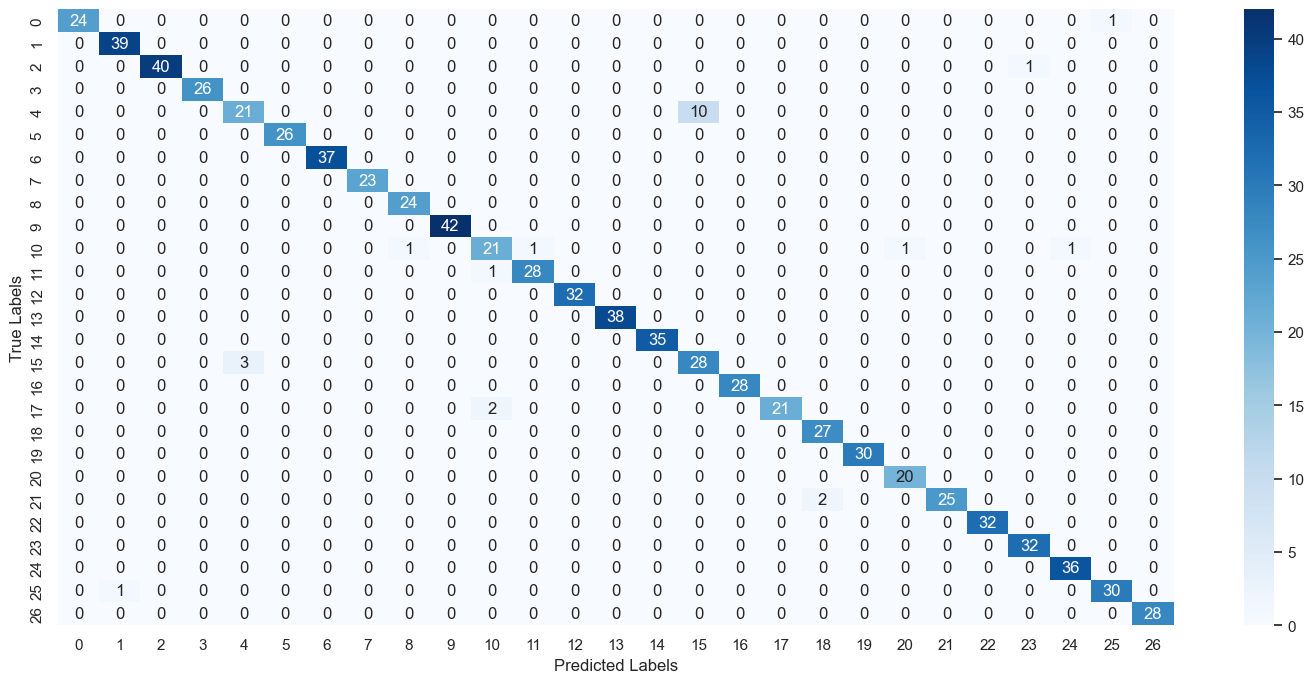

In [64]:
plt.figure(figsize = (18,8))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, xticklabels=y_test.unique(), yticklabels=y_test.unique(), cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [65]:
df_test[
    df_test['class'].isin([4, 15])
]

,utterance,intent,category,tags,tokenized_utterance,clean_doc,lf_0,lf_1,lf_2,lf_3,...,lf_92,lf_93,lf_94,lf_95,lf_96,lf_97,lf_98,lf_99,class,predictions
131,could you help me to take a quick look at my i...,check_invoice,INVOICE,BIP,"[could, help, take, quick, look, invoice]",could help take quick look invoice,0.140061,-0.013951,0.016303,-0.071647,...,-0.008207,-0.011574,0.004251,0.033254,-0.002748,0.009902,-0.014226,-0.006722,4,4
132,I don't know how to find the invoices from las...,check_invoice,INVOICE,BM,"[know, find, invoices, last, month]",know find invoices last month,0.171814,-0.014158,0.008364,-0.059018,...,0.003635,-0.005454,0.006736,-0.001906,0.009550,0.009303,-0.000369,-0.003652,4,15
133,I want assistance to find the invoices from June,check_invoice,INVOICE,BM,"[want, assistance, find, invoices, June]",want assistance find invoices June,0.249718,0.005434,0.026927,-0.162326,...,-0.016814,0.027277,-0.022029,-0.059084,-0.003230,-0.016704,0.008143,-0.000550,4,15
134,I need assistance to check my invoices,check_invoice,INVOICE,BM,"[need, assistance, check, invoices]",need assistance check invoices,0.403980,-0.129310,-0.089191,-0.090502,...,-0.033129,0.001833,-0.016267,0.038691,-0.020169,0.010001,-0.028240,-0.014621,4,4
135,I have to find my invoices,check_invoice,INVOICE,BM,"[find, invoices]",find invoices,0.077589,-0.025105,-0.008230,-0.057411,...,0.008924,0.024136,-0.011271,-0.053990,0.001152,-0.025040,0.029879,0.016939,4,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,send me the invoice,get_invoice,INVOICE,B,"[send, invoice]",send invoice,0.077105,-0.031999,-0.020777,-0.037264,...,0.025057,0.029345,-0.015722,-0.087610,0.007297,-0.035209,0.056715,0.037935,15,15
500,is it possible to get my invoice?,get_invoice,INVOICE,BI,"[possible, get, invoice]",possible get invoice,0.087646,-0.018643,-0.010634,-0.018053,...,0.007652,0.018138,0.002757,-0.043215,0.008017,-0.000803,0.014161,0.002281,15,15
501,I am trying to get the invoice from 2 purchase...,get_invoice,INVOICE,BM,"[trying, get, invoice, purchases, ago]",trying get invoice purchases ago,0.071137,-0.011237,-0.019408,-0.024225,...,0.005332,-0.015861,0.026962,0.011787,0.016233,0.025424,-0.017729,-0.013147,15,15
502,I am calling to get my invoices,get_invoice,INVOICE,BM,"[calling, get, invoices]",calling get invoices,0.082726,-0.030942,-0.016234,-0.057171,...,0.020782,0.065502,-0.002543,-0.071881,-0.030889,-0.080853,0.103893,0.019126,15,15


### Transfer learning

In [66]:
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    RobertaTokenizer,
    RobertaForSequenceClassification,
    BertTokenizer,
    BertForSequenceClassification,
    BertModel,
    BertTokenizerFast,
)

In [67]:
class CustomRobertaForSequenceClassification(RobertaForSequenceClassification):
    def __init__(self, config, weight=None):
        super().__init__(config)
        # Initialize the class weights
        self.weight = weight

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Standard forward pass
        outputs = super().forward(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        logits = outputs.logits
        # Modify the loss computation to include class weights
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.weight)
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            # Construct a new output object that includes the custom loss
            outputs = SequenceClassifierOutput(
                loss=loss,
                logits=logits,
                hidden_states=outputs.hidden_states,
                attentions=outputs.attentions,
            )
        return outputs

### BERT

#### BERT from HuggingFace

In [68]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

In [69]:
# Define a custom dataset
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [70]:
# Hyperparameters
MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5
NUM_CLASSES = 27

In [71]:
# Load pre-trained model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=NUM_CLASSES)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [76]:
# Data prep
df_train['class'] = df_train['intent'].map(class_map)

df_train['text'] = df_train['utterance']
df_val['text'] = df_val['utterance']
df_test['text'] = df_test['utterance']

df_train['labels'] = df_train['class']
df_val['labels'] = df_val['class']
df_test['labels'] = df_test['class']

train_texts, train_labels = list(df_train['text']), list(df_train['labels'])
val_texts, val_labels = list(df_val['text']), list(df_val['labels'])
test_texts, test_labels = list(df_test['text']), list(df_test['labels'])

In [77]:
# Create datasets
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, MAX_LENGTH)
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer, MAX_LENGTH)

In [78]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [79]:
# Setup GPU/CPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [80]:
# Setup optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

In [81]:
# Training loop
for epoch in range(EPOCHS):
    model.train()
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{EPOCHS}'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        
        # Set up optimizer and loss function
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_predictions = []
    val_true_labels = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            
            val_predictions.extend(preds.cpu().tolist())
            val_true_labels.extend(labels.cpu().tolist())

    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    val_f1 = f1_score(val_true_labels, val_predictions, average='weighted')
    print(f'Validation Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}')


Validation: 100%|███████████████████| 52/52 [00:23<00:00,  2.20it/s]


Validation Accuracy: 0.9976, F1 Score: 0.9976


Validation: 100%|███████████████████| 52/52 [00:23<00:00,  2.17it/s]


Validation Accuracy: 0.9976, F1 Score: 0.9976


Validation: 100%|███████████████████| 52/52 [00:23<00:00,  2.17it/s]

Validation Accuracy: 0.9988, F1 Score: 0.9988


In [83]:
# Test evaluation
model.eval()
test_predictions = []
test_true_labels = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        
        test_predictions.extend(preds.cpu().tolist())
        test_true_labels.extend(labels.cpu().tolist())

test_accuracy = accuracy_score(test_true_labels, test_predictions)
test_f1 = f1_score(test_true_labels, test_predictions, average='weighted')
print(f'Test Accuracy: {test_accuracy:.4f}, F1 Score: {test_f1:.4f}')

# Save the model
torch.save(model.state_dict(), 'text_classification_model.pth')

Testing: 100%|██████████████████████| 52/52 [00:24<00:00,  2.14it/s]


Test Accuracy: 1.0000, F1 Score: 1.0000


### Custom model from BERT

In [98]:
# Dataset

class NLUDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        # Tokenize the text and convert to tensor
        encoding = self.tokenizer(self.texts[idx], 
                                  truncation=True, 
                                  max_length=self.max_length, 
                                  padding='max_length', 
                                  return_tensors='pt')
        
        # Extract the input_ids and attention_mask
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        
        # Convert label to tensor
        label = torch.tensor(self.labels[idx])
        
        return {'input_ids': input_ids, 
                'attention_mask': attention_mask, 
                'labels': label}

In [99]:
# Model

class NLUModel(nn.Module):
    def __init__(self, num_classes):
        super(NLUModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
    
    def forward(self, input_ids, attention_mask):
        # Pass input through BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Get the [CLS] token representation
        pooled_output = outputs.pooler_output
        
        # Apply dropout and the final classification layer
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [86]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    for batch in tqdm(train_loader, desc='Training'):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [87]:
def evaluate(model, eval_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch in eval_loader:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            # Calculate accuracy
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_predictions += labels.shape[0]
            total_loss += loss.item()
    
    # Calculate average loss and accuracy
    avg_loss = total_loss / len(eval_loader)
    accuracy = correct_predictions.float() / total_predictions
    return avg_loss, accuracy

### Train custom model

In [95]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare data (assume we have texts and labels)
train_dataset = NLUDataset(train_texts, train_labels, tokenizer, max_length=128)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize model
model = NLUModel(num_classes=len(set(train_labels))).to(device)

In [97]:
# Set up optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    train(model, train_loader, optimizer, criterion, device)

    # Evaluate after each epoch
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Training: 100%|███████████████████| 205/205 [11:28<00:00,  3.36s/it]


Epoch 1/5
Val Loss: 0.3982, Val Accuracy: 0.9963


Training: 100%|███████████████████| 205/205 [11:17<00:00,  3.31s/it]


Epoch 2/5
Val Loss: 0.0806, Val Accuracy: 1.0000


Training: 100%|███████████████████| 205/205 [11:24<00:00,  3.34s/it]


Epoch 3/5
Val Loss: 0.0367, Val Accuracy: 1.0000


Training: 100%|███████████████████| 205/205 [11:18<00:00,  3.31s/it]


Epoch 4/5
Val Loss: 0.0213, Val Accuracy: 1.0000


Training: 100%|███████████████████| 205/205 [11:22<00:00,  3.33s/it]


Epoch 5/5
Val Loss: 0.0149, Val Accuracy: 1.0000


### Test set evaluation

In [100]:
model

NLUModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [104]:
# Test evaluation
model.eval()
test_predictions = []
test_true_labels = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        
        # Our customer model only returns logits, so no need to pass outputs.logits to torch.max()
        _, preds = torch.max(outputs, dim=1)
        
        test_predictions.extend(preds.cpu().tolist())
        test_true_labels.extend(labels.cpu().tolist())

test_accuracy = accuracy_score(test_true_labels, test_predictions)
test_f1 = f1_score(test_true_labels, test_predictions, average='weighted')
print(f'Test Accuracy: {test_accuracy:.4f}, F1 Score: {test_f1:.4f}')

# Save the model
torch.save(model.state_dict(), 'text_classification_model_NLU.pth')

Testing: 100%|██████████████████████| 52/52 [00:21<00:00,  2.44it/s]


Test Accuracy: 1.0000, F1 Score: 1.0000


### Purpose of [CLS] Token

Our model is using the [CLS] token representation (obtained via outputs.pooler_output) for a specific reason.

**In BERT, the [CLS] (Classification) token is a special token added at the beginning of every input sequence**
- It's designed to capture the overall meaning or representation of the entire input sequence.

**Sentence-Level Classification**
- The model is designed for sentence-level classification tasks (e.g., sentiment analysis, text classification). For such tasks, a single vector representing the entire input is often needed, rather than individual token representations.
    
**BERT's Design**
- BERT is trained in a way that the final hidden state of the [CLS] token can be used as an aggregate sequence representation. The pooler_output in BERT specifically corresponds to this [CLS] token representation, further processed through a dense layer and tanh activation.

**Efficiency**
- Using the [CLS] token representation is computationally efficient as it provides a fixed-size representation regardless of the input sequence length.

**Fine-tuning Approach**
- This approach aligns with the recommended fine-tuning procedure for BERT on classification tasks, where typically only a single dense layer is added on top of the [CLS] token representation.

**Alternative Approaches**

While using the [CLS] token is common, it's not the only approach.

Some alternatives include:
- Using the average of all token representations
- Using the last hidden state of all tokens and applying some form of pooling
- Using attention mechanisms over all token representations

In this specific implementation, the choice to use the [CLS] token representation (via outputs.pooler_output) indicates that the model is designed for tasks where a single vector representation of the entire input is sufficient for classification. This is a standard and effective approach for many NLP classification tasks when using BERT.

### Multi-task BERT

In [111]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

class MultitaskBERTModel(nn.Module):
    def __init__(self, num_classes, num_tokens):
        super(MultitaskBERTModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        
        # Layers for different tasks
        self.classification_layer = nn.Linear(self.bert.config.hidden_size, num_classes)
        self.token_classification_layer = nn.Linear(self.bert.config.hidden_size, num_tokens)
        self.regression_layer = nn.Linear(self.bert.config.hidden_size, 1)
        self.attention = nn.MultiheadAttention(self.bert.config.hidden_size, num_heads=8)

    def forward(self, input_ids, attention_mask, task='classification'):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        if task == 'classification':
            # 1. Sentence-level Classification (e.g., Sentiment Analysis)
            # Uses the [CLS] token representation for the entire sentence
            pooled_output = outputs.pooler_output
            return self.classification_layer(pooled_output)

        elif task == 'token_classification':
            # 2. Token-level tasks (e.g., Named Entity Recognition)
            # Uses embeddings for each token in the sequence
            token_embeddings = outputs.last_hidden_state
            return self.token_classification_layer(token_embeddings)

        elif task == 'seq2seq':
            # 3. Sequence-to-sequence tasks (e.g., Machine Translation)
            # Returns encoder outputs to be used by a separate decoder
            return outputs.last_hidden_state

        elif task == 'document_classification':
            # 4. Document-level tasks
            # Applies attention over all token representations
            token_embeddings = outputs.last_hidden_state
            attn_output, _ = self.attention(token_embeddings, token_embeddings, token_embeddings)
            doc_embedding = attn_output.mean(dim=1)
            return self.classification_layer(doc_embedding)

        elif task == 'multi_sentence':
            # 5. Multi-sentence tasks (e.g., Question Answering)
            # This would typically be handled in a separate method with multiple inputs
            raise NotImplementedError("Multi-sentence tasks require multiple input processing")

        elif task == 'token_interactions':
            # 6. Tasks requiring fine-grained token interactions
            # Returns token embeddings for further processing of interactions
            return outputs.last_hidden_state

        elif task == 'regression':
            # 7. Regression tasks
            # Similar to classification but with a single output
            pooled_output = outputs.pooler_output
            return self.regression_layer(pooled_output)

        else:
            raise ValueError("Unknown task type")

In [118]:
# Example usage
model = MultitaskBERTModel(num_classes=3, num_tokens=10)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare input
text = "This is an example sentence."
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

# Run model for different tasks
classification_output = model(inputs['input_ids'], inputs['attention_mask'], task='classification')
token_classification_output = model(inputs['input_ids'], inputs['attention_mask'], task='token_classification')
regression_output = model(inputs['input_ids'], inputs['attention_mask'], task='regression')
seq2seq_output = model(inputs['input_ids'], inputs['attention_mask'], task='seq2seq')

print("Classification output shape:", classification_output.shape)
print("Token classification output shape:", token_classification_output.shape)
print("Regression output shape:", regression_output.shape)
print("seq2seq output shape:", seq2seq_output.shape)

Classification output shape: torch.Size([1, 3])
Token classification output shape: torch.Size([1, 8, 10])
Regression output shape: torch.Size([1, 1])
seq2seq output shape: torch.Size([1, 8, 768])


**Sentence-level Classification**

Uses the [CLS] token representation, which is designed to capture the overall meaning of the input sequence. This is ideal for tasks like sentiment analysis or text classification.

**Token-level Tasks**

Utilizes embeddings for each token, suitable for tasks that require predictions for individual words, such as Named Entity Recognition or Part-of-Speech tagging.

**Sequence-to-sequence Tasks**

Returns the full sequence of token embeddings, which can be used as encoder outputs in tasks like machine translation or text summarization.

**Document-level Tasks**

Applies an attention mechanism over all token representations to create a document-level embedding, useful for longer text classification tasks.

**Multi-sentence Tasks**

Placeholder for tasks that involve processing multiple sentences separately, such as question answering. This would typically require a more complex input structure.

**Token Interaction Tasks**

Returns all token embeddings for tasks that need to model intricate relationships between tokens, like coreference resolution.

**Regression Tasks**

Similar to classification but with a single continuous output, suitable for tasks like predicting ratings or scores.

### Attention Mask

The attention mask is a binary tensor that indicates which tokens the model should pay attention to and which it should ignore. It's used in multi-class classification (and other tasks) for several reasons:

- **Padding**: When we pad sequences to a fixed length, we use the attention mask to tell the model which tokens are actual input and which are padding. The mask has 1s for real tokens and 0s for padding tokens.

- **Efficiency**: By ignoring padded tokens, the model can process batches more efficiently.
- **Correct Self-Attention**: In BERT's self-attention mechanism, the mask ensures that the model doesn't attend to padding tokens when computing attention scores.

While the core classification task doesn't directly use the attention mask, it's crucial for the underlying BERT model to process the input correctly, which in turn affects the classification performance.

The attention mask is particularly important in NLP tasks because input sequences often have varying lengths, and we need a way to handle this variability in a fixed-size neural network architecture.

This detailed setup allows for effective fine-tuning of a pre-trained BERT model for your specific 27-class text classification task, handling the complexities of text data while leveraging the power of transfer learning from a large pre-trained model.

### Fine-tuning vs. Feature Extraction

In the current code, we're performing fine-tuning. This means we're updating all the weights in the pre-trained BERT model as well as the classification layer on top.

The alternative would be feature extraction, where we freeze the BERT layers and only train the classification layer.

#### Why Fine-tune

Fine-tuning can often lead to better performance, especially if our task is significantly different from BERT's pre-training task or if you have a substantial amount of task-specific data.

It allows the model to adapt its learned features to your specific task.

#### Potential Drawbacks

Fine-tuning can be more prone to overfitting, especially with small datasets.
It's more computationally expensive than feature extraction.

If you want to only update the classification layer and keep the BERT weights frozen (i.e., perform feature extraction), you can modify the code like this:

#### Freeze BERT parameters

Add this to model definition:

    for param in model.bert.parameters():
        param.requires_grad = False
    

In [ ]:
class NLUModel(nn.Module):
    def __init__(self, num_classes):
        super(NLUModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
        
        # Freeze BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False
    
    def forward(self, input_ids, attention_mask):
        # Pass input through BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Get the [CLS] token representation
        pooled_output = outputs.pooler_output
        
        # Apply dropout and the final classification layer
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

model = NLUModel(num_classes=len(set(train_labels))).to(device)

# Only optimize parameters of the classification head
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

This modification will freeze the BERT layers and only update the classification layer during training.
Alternatively, if you want a middle ground approach, you could freeze only some layers of BERT. For example, to freeze the first 6 layers (out of 12 in BERT-base):

In [ ]:
# Freeze the first 6 layers of BERT
for name, param in model.named_parameters():
    if "encoder.layer" in name:
        layer_num = int(name.split(".")[3])
        if layer_num < 6:
            param.requires_grad = False

optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

To verify that only the classification layer is being trained, we can add this check:

In [106]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable parameters: {count_trainable_parameters(model)}")

Trainable parameters: 109503003


This should show a much smaller number of trainable parameters compared to fine-tuning the entire model.

When using the **BertForSequenceClassification** model instead of the custom NLUModel, you can freeze the BERT layers like this:

In [108]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=NUM_CLASSES)

# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classification head
for param in model.classifier.parameters():
    param.requires_grad = True

model = model.to(device)

# Only optimize parameters that require gradients
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


By freezing the BERT layers, we're essentially using BERT as a fixed feature extractor.
The model will produce BERT embeddings for the input text, and only the classification layer on top will be trained to map these embeddings to your specific classes.

This approach can be beneficial when:

- You have a small dataset and want to avoid overfitting.
- Your task is similar to BERT's pre-training tasks, so the pre-trained features are already well-suited for your problem.
- You want to reduce training time and computational resources.

However, if we have a large dataset or if your task is significantly different from BERT's pre-training,
fine-tuning the entire model (or at least the upper layers) might yield better results.

It's often worth experimenting with both approaches to see which works best for our specific task.

### Unbalanced classes

**Class weights**

We can assign higher weights to underrepresented classes. This approach tells the model to pay more attention to minority classes during training.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.FloatTensor(class_weights).to(device)

# Modify the loss function to use weights
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# In the training loop, use this criterion instead of the default one
outputs = model(input_ids, attention_mask=attention_mask)
loss = criterion(outputs.logits, labels)

#### Oversampling

You can oversample minority classes to balance the dataset.
A popular method is SMOTE (Synthetic Minority Over-sampling Technique), but for text data, you might simply duplicate samples from minority classes

In [ ]:
from collections import Counter
from torch.utils.data import WeightedRandomSampler

# Count samples per class
class_counts = Counter(train_labels)
num_samples = len(train_labels)

# Compute weights for each sample
class_weights = {c: num_samples / count for c, count in class_counts.items()}
sample_weights = [class_weights[label] for label in train_labels]

# Create a sampler
sampler = WeightedRandomSampler(sample_weights, num_samples=num_samples, replacement=True)

# Use this sampler in your DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)

#### Focal Loss

Focal Loss is designed to address class imbalance by down-weighting the loss assigned to well-classified examples.
It's particularly useful for datasets with extreme imbalance.

In [ ]:
import torch.nn.functional as F

class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Use Focal Loss instead of standard Cross Entropy
criterion = FocalLoss()

# In the training loop
outputs = model(input_ids, attention_mask=attention_mask)
loss = criterion(outputs.logits, labels)

#### Adjust evaluation metrics

For imbalanced datasets, accuracy can be misleading.
Consider using metrics like F1-score (which we're already using), precision, recall, or Matthews Correlation Coefficient.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, matthews_corrcoef

# In your evaluation function
def compute_metrics(true_labels, predictions):
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')
    mcc = matthews_corrcoef(true_labels, predictions)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'mcc': mcc
    }

# Use this function after making predictions
metrics = compute_metrics(true_labels, predictions)
print(metrics)

#### Adjust decision threshold

After training, you can adjust the decision threshold for each class based on validation set performance.

In [ ]:
# After training, on validation set
model.eval()
all_outputs = []
all_labels = []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        all_outputs.append(outputs.logits)
        all_labels.append(labels)

all_outputs = torch.cat(all_outputs, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Find optimal threshold for each class
thresholds = []
for i in range(NUM_CLASSES):
    best_f1 = 0
    best_threshold = 0.5
    for threshold in np.arange(0.3, 0.7, 0.05):
        preds = (torch.softmax(all_outputs, dim=1)[:, i] > threshold).float()
        f1 = f1_score(all_labels == i, preds, average='binary')
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    thresholds.append(best_threshold)

# Use these thresholds for prediction
def predict_with_threshold(outputs):
    probs = torch.softmax(outputs, dim=1)
    return torch.tensor([1 if probs[i] > thresholds[i] else 0 for i in range(NUM_CLASSES)])

# In your test loop
predictions = [predict_with_threshold(output) for output in test_outputs]

### Differences between using BertForSequenceClassification and creating a custom model class

#### Pre-built vs Custom Architecture

BertForSequenceClassification is a pre-built model provided by the Hugging Face Transformers library.

It's designed to be a ready-to-use solution for sequence classification tasks.
The custom NLUModel class allows you to define your own architecture, giving you more control over the model structure.


#### Hidden Layers

BertForSequenceClassification typically includes additional hidden layers between the BERT output and the final classification layer.
In the custom NLUModel, you're directly connecting the BERT output to the final classification layer through a dropout layer.


#### Pooling Strategy

BertForSequenceClassification uses the first token ([CLS]) output as the pooled representation by default, but it has options to use other pooling strategies.
In your custom model, you're explicitly using the pooled output from BERT (outputs.pooler_output).

#### Loss Computation

BertForSequenceClassification can compute the loss internally if you provide labels during the forward pass.
With the custom model, you need to define and compute the loss separately.


#### Flexibility

The custom model gives you more flexibility to modify the architecture, add layers, or incorporate other features.
BertForSequenceClassification is more rigid but often easier to use out-of-the-box.


#### Output Format

BertForSequenceClassification returns a SequenceClassifierOutput object which includes loss (if labels are provided), logits, and hidden states (if requested).
Your custom model returns only the logits.

#### Fine-tuning Behavior

BertForSequenceClassification is designed with fine-tuning in mind and includes options like freeze_base_model to easily control which parts of the model are updated during training.
With the custom model, you have to manually implement any freezing of layers if desired.


#### Compatibility with Hugging Face Ecosystem

BertForSequenceClassification is fully compatible with Hugging Face's training loops, optimizers, and other utilities.
The custom model may require some additional work to fully integrate with all Hugging Face features.

In practice, BertForSequenceClassification is often sufficient and convenient for many sequence classification tasks. However, creating a custom model like NLUModel can be beneficial when you need more control over the architecture, want to add specific layers or features, or are looking to experiment with different model structures.

### Softmax vs Linear activation in output layer

#### Why does Bert use a linear layer instead of a softmax?

**nn.CrossEntropyLoss** combines _log_softmax_ and _NLLLoss_ which means we should not apply softmax at the end of your network output.
So we are not required to apply softmax since the criterion takes care of it.

If we want to use softmax at the end, then you should apply log after that(as mentioned above) and use NLLLoss as the criterion.

The pooled output is passed through classification head (linear layer) to get the logits.

CrossEntropyLoss does not require softmax, it calculates loss using logits.

BertForSequenceClassification returns logits, then you can the apply softmax on the returned logits to get the class scores.